In [10]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from scipy.sparse import csr_matrix
import time
import csv

In [11]:
# To print big matrices as whole
np.set_printoptions(linewidth=np.inf, threshold=np.inf)

In [12]:
instance_list = ['car-s-91','car-f-92','ear-f-83', 'hec-s-92', 'kfu-s-93', 'lse-f-91', 'pur-s-93', 'rye-s-93', 'sta-f-83', 'tre-s-92', 'uta-s-92', 'ute-s-92', 'yor-f-83']

In [18]:
data_folder = '../data'
class Instance():
    def __init__(self, file_name):
        self.file_name = file_name
        self.get_room_data()
        self.get_room_preference()
        self.get_course_data()
        self.get_dates()
        self.get_times()
        self.get_datetime_preference()
        self.get_student_data()
        self.max_violation_dict = {"overlap violation" : 1, #self.numCourses,
                                    "capacity violation" : 1, #self.numRooms * self.numDateTime,
                                    "facility violation" : 1, #self.numCourses,
                                    "proximity penalty" : 1, #np.triu(self.conflict_boolean, k=1).sum() * (2**5),
                                    "date time penalty" : 1, #2**5 * self.numCourses,
                                    "room penalty" : 1 #2**5 *self.numCourses
                                    }
        print(f"Created instance {file_name}.")
        print(f"number of courses = {self.numCourses}, number of students = {self.numStudents}")
        print(f"number of timeslots = {self.numDateTime}, number of rooms = {self.numRooms}")
        
    def get_room_data(self):
        self.room_df = pd.read_csv(f"{data_folder}/{self.file_name}/room_data.csv")
        self.capacityList = self.room_df['Capacity'].to_numpy(int)
        self.roomList = self.room_df['RoomId'].to_numpy()
        self.numRooms = len(self.roomList)
        self.r_f_matrix = self.room_df.drop(['RoomId', 'Capacity'], axis=1).to_numpy(int)
        self.roomIndex = {room: idx for idx, room in enumerate(self.roomList)}
        
    def get_room_preference(self):
        self.room_preference_df = pd.read_csv(f"{data_folder}/{self.file_name}/room_preference.csv")
        self.r_pref_matrix = self.room_preference_df.drop(['courseId'], axis=1).to_numpy(int)
        
    def get_course_data(self):
        self.course_df = pd.read_csv(f"{data_folder}/{self.file_name}/course_data.csv")
        self.courseList = self.course_df['courseId'].to_numpy()
        self.numCourses = len(self.courseList)
        self.courseIndex = {course: idx for idx, course in enumerate(self.courseList)}
        self.numStudentsList = self.course_df['numStudents'].to_numpy(int)
        self.c_f_matrix = self.course_df.drop(['courseId', 'numStudents'], axis=1).to_numpy(int)
        self.c_r_feasible = self.create_c_r_feasibility().astype(int)
        
    def get_dates(self):
        self.date_df = pd.read_csv(f"{data_folder}/{self.file_name}/dates.csv")
        self.dateList = self.date_df['Date'].to_numpy()
        self.tDayList = self.date_df['T-Day'].to_numpy()
        self.numDays = len(self.dateList)
        
    def get_times(self):
        self.time_df = pd.read_csv(f"{data_folder}/{self.file_name}/times.csv")
        self.timeList = self.time_df['Time'].to_numpy()
        self.numTime = len(self.timeList)
        self.dateTimeList = np.array([date + 'T' + time for date in self.dateList for time in self.timeList])
        self.numDateTime = len(self.dateTimeList)
        self.datetime_tday = {self.dateTimeList[i]:self.tDayList[i//self.numTime] for i in range(self.numDateTime)}
        
    def get_datetime_preference(self):
        self.datetime_preference_df = pd.read_csv(f"{data_folder}/{self.file_name}/datetime_preference.csv")
        self.d_pref_matrix = self.datetime_preference_df.drop(['courseId'], axis=1).to_numpy(int)              
        
    def get_student_data(self):
        self.student_df = pd.read_csv(f"{data_folder}/{self.file_name}/student_data.csv")
        self.studentList = self.student_df['rollNum'].to_numpy()
        self.student_df.set_index('rollNum', inplace=True)
        self.numStudents = len(self.studentList)
        self.studentIndex = {student: idx for idx, student in enumerate(self.studentList)}
        self.s_c_matrix =  self.create_s_c_matrix().astype(int)
        self.s_c_sparse = csr_matrix(self.s_c_matrix) # converting to sparse matrix due to large size
        self.conflict_matrix = self.s_c_sparse.T.dot(self.s_c_sparse).toarray()
        self.conflict_boolean = self.conflict_matrix.astype(bool)
        
    def create_s_c_matrix(self):
        s_c_matrix = np.zeros((self.numStudents, self.numCourses), dtype=int) # Student- Course boolean matrix from dataset
        for student in self.studentList:
            courses = self.student_df.at[student, 'coursesEnrolled'].split()
            s_id = self.studentIndex[student]
            for course in courses:
                c_id = self.courseIndex[course]
                s_c_matrix[s_id, c_id] = 1
        return s_c_matrix
    
    def create_c_r_feasibility(self):
        total_facilities_required = self.c_f_matrix.sum(axis=1)[:,np.newaxis]
        total_facilities_available = np.dot(self.c_f_matrix, self.r_f_matrix.T)
        self.c_r_facility = (total_facilities_available >= total_facilities_required).astype(int)
        
        capacity_required = self.numStudentsList[:,np.newaxis]
        capacity_available = self.capacityList
        self.c_r_capacity = (capacity_available >= capacity_required).astype(int)
        
        return self.c_r_facility & self.c_r_capacity

In [19]:
class Timetable():
    
    def __init__(self, instance, r_a, d_a):
        self.instance = instance
        self.r_a = r_a
        self.d_a = d_a
        self.get_instance_values()
        self.create_matrices()
        self.penalty_dict = {"overlap violation" : self.create_overlap_check().sum(),
                            "capacity violation" : self.create_capacity_check().sum(),
                            "facility violation" : self.create_facility_check().sum(),
                            "proximity penalty" : self.create_proximity_matrix().sum(),
                            "date time penalty" : self.create_date_penalty_matrix().sum(),
                            "room penalty" : self.create_room_penalty_matrix().sum()
                            }
        self.normalized_penalty = {name : self.penalty_dict[name]/ instance.max_violation_dict[name] for name in self.penalty_dict}
        self.soft_penalty = sum(list(self.normalized_penalty.values())[3:])
        self.hard_penalty = sum(list(self.normalized_penalty.values())[:3])
        
    def get_instance_values(self):
        self.numCourses = self.instance.numCourses
        self.numRooms = self.instance.numRooms
        self.numDateTime = self.instance.numDateTime
        
    def create_matrices(self):
        self.c_d_matrix = np.eye(self.numDateTime, dtype=int)[self.d_a]
        self.c_r_matrix = np.eye(self.numRooms, dtype=int)[self.r_a]
        #self.s_d_matrix =  (csr_matrix(self.instance.s_c_matrix).dot(csr_matrix(self.c_d_matrix))).toarray()  #np.dot(self.instance.s_c_matrix, self.c_d_matrix) #self.s_c_sparse.T.dot(self.s_c_sparse).toarray()
        
        self.overlap_check = self.create_overlap_check()
        self.capacity_check = self.create_capacity_check()
        self.facility_check = self.create_facility_check()
        self.proximity_matrix = self.create_proximity_matrix()
        
    def create_overlap_check(self):
        return ((np.dot(self.instance.conflict_boolean, self.c_d_matrix)-1) * self.c_d_matrix).sum(axis=1).astype(bool)
    
    def create_capacity_check(self):
        c_r_student = self.c_r_matrix * self.instance.numStudentsList[:,None] # in course-room binary matrix, change 1 to number of students writng that exma
        r_d_student = (csr_matrix(c_r_student).T.dot(csr_matrix(self.c_d_matrix))).toarray()                            #np.dot(c_r_student.T, self.c_d_matrix)
        return (r_d_student > self.instance.capacityList[:,np.newaxis] ).astype(int)
    
    def create_facility_check(self):
        required_facility = self.instance.c_f_matrix
        available_facility = self.instance.r_f_matrix[self.r_a, :]
        return (required_facility > available_facility).sum(axis=1).astype(bool)

    def create_proximity_matrix(timetable):
        # upper triangular matrix of size (numCourse x numCourse) that shows proximity of two courses if they have conflict
        tdayAssigned = timetable.instance.tDayList[timetable.d_a // timetable.instance.numTime]  # Calculate tday assignments
        diff_matrix = np.abs(tdayAssigned[:, None] - tdayAssigned)  # Calculate absolute differences
        proximity_matrix = np.triu(np.where(diff_matrix < 5, np.power(2, abs(5 - diff_matrix)), 0), k=1)  # Calculate proximity penalty
        return proximity_matrix*timetable.instance.conflict_boolean
    
    def create_date_penalty_matrix(timetable):
        c_d_preference = timetable.c_d_matrix* timetable.instance.d_pref_matrix
        return np.where((c_d_preference==5) | (c_d_preference==0), 0 , 2**(5-c_d_preference))
    
    def create_room_penalty_matrix(timetable):
        return timetable.c_r_matrix*np.where(timetable.instance.r_pref_matrix==5, 0, 2**(5-timetable.instance.r_pref_matrix))
    
    def display(self):
        data = {"courses" : self.instance.courseList,
                "room" : [self.instance.roomList[room] for room in self.r_a],
                "datetime" : [self.instance.dateTimeList[datetime] for datetime in self.d_a]
                }
        return pd.DataFrame(data)
    def student_index_timetable(self, index):
        print(f"Timetable for student with roll number {self.instance.studentList[index]} ")
        return self.display()[self.instance.s_c_matrix[index].astype(bool)].sort_values(by=['datetime'])

In [20]:
def create_timetable(instance, heuristic='random'):
    numCourses = instance.numCourses
    numDateTime = instance.numDateTime
    numRooms = instance.numRooms
    shuffledDatetimeList = np.random.permutation(np.arange(numDateTime))
    
    # Initialize assignments
    d_a = np.full(numCourses, -1)
    r_a = np.full(numCourses, -1)
    r_d_capacity = np.tile(instance.capacityList, (numDateTime, 1))
    
    # Initialize course order based on heuristic
    
    if heuristic == 'conflict_count':
        conflict_count = instance.conflict_boolean.sum(axis=1)
        sorted_courses = np.argsort(conflict_count)[::-1]
    elif heuristic == 'conflict_degree':
        conflict_degree = instance.conflict_matrix.sum(axis=1)
        sorted_courses = np.argsort(conflict_degree)[::-1]
    else:
        raise ValueError(f"Unknown heuristic: {heuristic}")

    datetime_course = {dt: [] for dt in range(numDateTime)}
    
    # Assign courses to datetimes and rooms
    for course in sorted_courses:
        required_capacity = instance.numStudentsList[course]
        
        # Find available datetimes with no conflicts
        available_datetimes = []
        for dt in shuffledDatetimeList:
            if all(not instance.conflict_boolean[course, other_course] for other_course in datetime_course[dt]):
                available_datetimes.append(dt)
        
        if not available_datetimes:
            return None, None

        # Find available rooms for the selected datetime
        room_assigned = False
        for chosen_dt in available_datetimes:
            available_rooms = [room for room in range(numRooms) 
                               if instance.c_r_facility[course, room] and r_d_capacity[chosen_dt, room] >= required_capacity]
            if available_rooms:
                chosen_room = np.random.choice(available_rooms)
                d_a[course] = chosen_dt
                r_a[course] = chosen_room
                r_d_capacity[chosen_dt, chosen_room] -= required_capacity
                datetime_course[chosen_dt].append(course)
                room_assigned = True
                break
        
        if not room_assigned:
            return None, None
    
    return r_a, d_a


In [155]:
def create_population(instance, heuristic='conflict_count', size=100, leave = True):
    population = []
    for _ in tqdm(range(size), leave = leave):
        r_a = d_a = None
        while r_a is None:
            r_a, d_a = create_timetable(instance, heuristic )
        timetable = Timetable(instance, r_a, d_a)
        population.append(timetable)
    return population

In [156]:
def create_random_population(instance, size=100, leave=True):
    population = []
    for _ in tqdm(range(size), leave = leave):
        d_a = np.random.randint(low=0, high=instance.numDateTime, size=instance.numCourses)
        r_a = np.random.randint(low=0, high=instance.numRooms, size=instance.numCourses)
        population.append(Timetable(instance, r_a, d_a))
    return population

In [23]:
def tournament_selection(population, pool_size, k=3):
    population = np.array(population)
    selected = []
    for i in range(pool_size):
        tournament_indices = np.random.choice(len(population), size=k, replace=False)
        tournament = population[tournament_indices]
        winner = min(tournament, key=lambda x: x.soft_penalty)
        selected.append(winner)
    return selected

In [24]:
def crossover(parent1, parent2, crossover_prob = 0.8):
    # if np.random.random() > crossover_prob:
    #     return parent1, parent2
    
    instance = parent1.instance
    numCourses = instance.numCourses
    ra_1 = parent1.r_a
    ra_2 = parent2.r_a
    da_1 = parent1.d_a
    da_2 = parent2.d_a

    r_crossover = np.random.randint(1, numCourses)
    ra_3 = np.concatenate((ra_1[:r_crossover], ra_2[r_crossover:]))
    ra_4 = np.concatenate((ra_2[:r_crossover], ra_1[r_crossover:]))

    d_crossover = np.random.randint(1, numCourses)
    da_3 = np.concatenate((da_1[:d_crossover], da_2[d_crossover:]))
    da_4 = np.concatenate((da_2[:d_crossover], da_1[d_crossover:]))

    return Timetable(instance, ra_3, da_3), Timetable(instance, ra_4, da_4)

In [25]:
def mutation(parent, mutation_rate = 0.5):
    # room
    instance = parent.instance
    mutated_room = parent.r_a.copy()
    random_numbers = np.random.rand(instance.numCourses)
    mutate_mask = random_numbers < mutation_rate
    mutated_room[mutate_mask] = np.random.randint(instance.numRooms, size = mutate_mask.sum())
    #datetime
    mutated_datetime = parent.d_a.copy()
    random_numbers = np.random.rand(instance.numCourses)
    mutate_mask = random_numbers < mutation_rate
    mutated_datetime[mutate_mask] = np.random.randint(instance.numDateTime, size = mutate_mask.sum())

    return Timetable(instance, mutated_room, mutated_datetime)

In [26]:
def weighted_penalty(timetable, weight= 100):
    return timetable.soft_penalty + timetable.hard_penalty*weight

In [27]:
def euclidean_distance(sol1, sol2):
    room_distance = np.sum((sol1.r_a - sol2.r_a)**2)
    datetime_distance = np.sum((sol1.d_a - sol2.d_a)**2)
    return np.sqrt(room_distance + datetime_distance)

In [28]:
def repair(input_solution, feasible_solutions, curr_depth=0, verbose=False):
    instance = input_solution.instance
    
    print(verbose * f"Repairing: depth={curr_depth}, hard_penalty={input_solution.hard_penalty}\n", end='')
    
    if input_solution.hard_penalty == 0 or curr_depth > 50:
        print(verbose * f"Returning solution: depth={curr_depth}, hard_penalty={input_solution.hard_penalty}\n", end='')
        return input_solution

    best_donor = min(feasible_solutions, key=lambda sol: euclidean_distance(input_solution, sol))
    print(verbose * f"Best donor selected: {best_donor}\n", end='')
        
    for i in range(instance.numRooms):
        if input_solution.overlap_check[i] or input_solution.facility_check[i] or input_solution.capacity_check[input_solution.r_a[i], input_solution.d_a[i]]:
            r_a_copy = input_solution.r_a[:]
            d_a_copy = input_solution.d_a[:]
            d_a_copy[i] = best_donor.d_a[i]  # exchange date with best donor
            solution_copy = Timetable(instance, r_a_copy, d_a_copy)
            
            print(verbose * f"Trying date exchange: index={i}, donor date={best_donor.d_a[i]}\n", end='')
            
            if solution_copy.hard_penalty < input_solution.hard_penalty:  # check for reduction in hard penalty
                print(verbose * f"Date exchange improved solution: index={i}, new hard_penalty={solution_copy.hard_penalty}\n", end='')
                return repair(solution_copy, feasible_solutions, curr_depth+1, verbose)
            else:
                r_a_copy[i] = best_donor.r_a[i]  # exchange room with best donor
                solution_copy = Timetable(instance, r_a_copy, d_a_copy)
                
                print(verbose * f"Trying room exchange: index={i}, donor room={best_donor.r_a[i]}\n", end='')
                
                if solution_copy.hard_penalty < input_solution.hard_penalty:  # check for reduction in hard penalty
                    print(verbose * f"Room exchange improved solution: index={i}, new hard_penalty={solution_copy.hard_penalty}\n", end='')
                    return repair(solution_copy, feasible_solutions, curr_depth+1, verbose)
                else:
                    d_a_copy[i] = input_solution.d_a[i]  # revert date back to original
                    solution_copy = Timetable(instance, r_a_copy, d_a_copy)
                    
                    print(verbose * f"Reverting date: index={i}, original date={input_solution.d_a[i]}\n", end='')
                    
                    if solution_copy.hard_penalty < input_solution.hard_penalty:  # check for reduction in hard penalty
                        print(verbose * f"Reversion improved solution: index={i}, new hard_penalty={solution_copy.hard_penalty}\n", end='')
                        return repair(solution_copy, feasible_solutions, curr_depth+1, verbose)
                
    print(verbose * f"No improvement found at depth {curr_depth}\n", end='')
    return input_solution


In [139]:
# Criteria function
criteria = lambda sol : sol.soft_penalty + 1e9 * sol.hard_penalty

def genetic_algorithm(instance, initial_population, generations=100, pop_size=100, pool_size=50, track=False):
    population = initial_population

    # Parameters
    crossover_rate = 0.8
    mutation_rate = 0.5
    tournament_size = 5
    elitism_count = 2

    # Lists to store penalties and timing for each generation
    if track:
        best_fitness = {}
        worst_fitness = {}
        generation_times = {}

    start_time = time.time()

    for generation in tqdm(range(generations)):

        # Selection
        mating_pool = tournament_selection(population, pool_size, tournament_size)
        
        # Crossover and Mutation
        offsprings = []
        for i in range(0, pool_size-1, 2):
            parent1 = mating_pool[i]
            parent2 = mating_pool[(i+1) % pool_size]
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            
            if np.random.rand() < mutation_rate:
                child1 = mutation(child1, mutation_rate)
            if np.random.rand() < mutation_rate:
                child2 = mutation(child2, mutation_rate)
            
            offsprings.extend([child1, child2])
        
        top_offspring = repair(sorted(offsprings, key=lambda sol: sol.soft_penalty)[0], population, verbose=False)
        offsprings.append(top_offspring)
        
        # Combine and Select Next Generation
        combined_population = population + offsprings
        combined_population = sorted(combined_population, key=criteria)
        population = combined_population[:pop_size]
        
        # Track the best and worst penalties for each generation
        best_fitness[f"BF {generation}"] = criteria(population[0])
        worst_fitness[f"WF {generation}"] = criteria(population[-1])
        generation_times[f"T {generation}"] = time.time() - start_time
        
        
        if criteria(population[0]) == criteria(population[-1]): # if premature convergence add diversity
            print(f"Generation {generation}: Avoiding premature convergence")
            population = population[:10] + create_random_population(instance, 90, leave=False)
        
        if generation % (generations//10) == 0 or generation == generations:
            print(f"Generation {generation}: Best = {criteria(population[0])}, Worst = {criteria(population[-1])}")

        
    if track:
        return population, best_fitness, worst_fitness, generation_times
    
    return population



In [140]:
instance_list = ['car-s-91','car-f-92','ear-f-83', 'hec-s-92', 'kfu-s-93', 'lse-f-91', 'pur-s-93', 'rye-s-93', 'sta-f-83', 'tre-s-92', 'uta-s-92', 'ute-s-92', 'yor-f-83']

In [141]:
instance = Instance(instance_list[3])

Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


In [158]:
feasible_population = create_population(instance, size=10)
infeasible_population = create_random_population(instance, 90)
initial_population = feasible_population+infeasible_population

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

In [143]:
population, best_fitness, worst_fitness, generation_times = genetic_algorithm(instance, initial_population, track=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7472.0, Worst = 98000010272.0
Generation 10: Best = 7472.0, Worst = 8000007404.0
Generation 20: Best = 7446.0, Worst = 2000007428.0
Generation 30: Best = 7428.0, Worst = 1000007422.0
Generation 40: Best = 7416.0, Worst = 7496.0
Generation 49: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7410.0, Worst = 97000009484.0
Generation 54: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7410.0, Worst = 99000010172.0
Generation 66: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7410.0, Worst = 63000009746.0
Generation 72: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 77: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7410.0, Worst = 74000009060.0
Generation 83: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 89: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7410.0, Worst = 99000010438.0
Generation 94: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

In [144]:
infeasible_population[0].penalty_dict

{'overlap violation': 62,
 'capacity violation': 23,
 'facility violation': 16,
 'proximity penalty': 8854,
 'date time penalty': 408,
 'room penalty': 1450}

In [145]:
len(generation_times)

100

In [146]:
best_fitness

{'BF 0': 7472.0,
 'BF 1': 7472.0,
 'BF 2': 7472.0,
 'BF 3': 7472.0,
 'BF 4': 7472.0,
 'BF 5': 7472.0,
 'BF 6': 7472.0,
 'BF 7': 7472.0,
 'BF 8': 7472.0,
 'BF 9': 7472.0,
 'BF 10': 7472.0,
 'BF 11': 7472.0,
 'BF 12': 7472.0,
 'BF 13': 7472.0,
 'BF 14': 7472.0,
 'BF 15': 7472.0,
 'BF 16': 7472.0,
 'BF 17': 7446.0,
 'BF 18': 7446.0,
 'BF 19': 7446.0,
 'BF 20': 7446.0,
 'BF 21': 7446.0,
 'BF 22': 7446.0,
 'BF 23': 7446.0,
 'BF 24': 7446.0,
 'BF 25': 7446.0,
 'BF 26': 7446.0,
 'BF 27': 7428.0,
 'BF 28': 7428.0,
 'BF 29': 7428.0,
 'BF 30': 7428.0,
 'BF 31': 7428.0,
 'BF 32': 7428.0,
 'BF 33': 7428.0,
 'BF 34': 7428.0,
 'BF 35': 7428.0,
 'BF 36': 7426.0,
 'BF 37': 7426.0,
 'BF 38': 7422.0,
 'BF 39': 7422.0,
 'BF 40': 7416.0,
 'BF 41': 7416.0,
 'BF 42': 7410.0,
 'BF 43': 7410.0,
 'BF 44': 7410.0,
 'BF 45': 7410.0,
 'BF 46': 7410.0,
 'BF 47': 7410.0,
 'BF 48': 7410.0,
 'BF 49': 7410.0,
 'BF 50': 7410.0,
 'BF 51': 7410.0,
 'BF 52': 7410.0,
 'BF 53': 7410.0,
 'BF 54': 7410.0,
 'BF 55': 7410.0,
 '

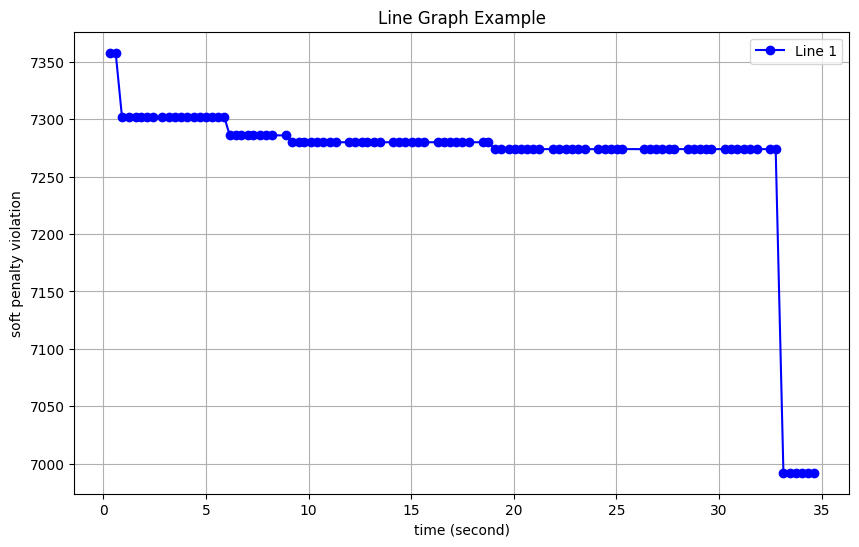

In [154]:
import matplotlib.pyplot as plt

# Example data
x = generation_times.values()
y = best_fitness.values()

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='b', label='Line 1')

# Add titles and labels
plt.title('Line Graph Example')
plt.xlabel('time (second)')
plt.ylabel('soft penalty violation')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [153]:
import csv
import os

# List of instances and field names for the CSV
instance_list = ['car-s-91','car-f-92','ear-f-83', 'hec-s-92', 'kfu-s-93', 'lse-f-91', 'pur-s-93', 'rye-s-93', 'sta-f-83', 'tre-s-92', 'uta-s-92', 'ute-s-92', 'yor-f-83']
inst_fieldnames = ['Instance', 'Trial'] + [f"BF {i}" for i in range(100)] + [f"WF {i}" for i in range(100)] + [f"T {i}" for i in range(100)]

# Loop through the specific file names and trials
for file_name in instance_list[1, 2, ]:
    for i in range(10):
        # Assume Instance and the functions are defined elsewhere
        instance = Instance(file_name)
        feasible_population = create_population(instance, size=10)
        infeasible_population = create_random_population(instance, 90)
        initial_population = feasible_population + infeasible_population
        population, best_fitness, worst_fitness, generation_times = genetic_algorithm(instance, initial_population, track=True)
        
        # Construct the CSV file path
        csv_file = f"../docs/performance_tracking/{file_name}.csv"
        
        # Data to be written
        dict1 = {'Instance': file_name, 'Trial': i}
        data = {**dict1, **best_fitness, **worst_fitness, **generation_times}
        
        # Check if the file exists
        file_exists = os.path.isfile(csv_file)
        
        # Open the file in append mode and write data
        with open(csv_file, mode='a', newline='') as file:
            writer = csv.DictWriter(file, fieldnames=inst_fieldnames)
            if not file_exists:
                writer.writeheader()
            writer.writerow(data)
            file.flush()
        
        # Print confirmation message
        print(f"Data saved to {csv_file}")


Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7442.0, Worst = 98000010694.0
Generation 10: Best = 7370.0, Worst = 8000007462.0
Generation 20: Best = 7334.0, Worst = 7370.0
Generation 24: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7286.0, Worst = 7334.0
Generation 36: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7286.0, Worst = 69000008960.0
Generation 42: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 47: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7286.0, Worst = 79000009478.0
Generation 53: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 59: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7286.0, Worst = 98000010646.0
Generation 64: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7286.0, Worst = 97000010296.0
Generation 76: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7286.0, Worst = 66000009184.0
Generation 82: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 88: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7286.0, Worst = 90000010196.0
Generation 95: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7316.0, Worst = 99000009848.0
Generation 10: Best = 7288.0, Worst = 1000007306.0
Generation 12: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 17: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 20: Best = 7288.0, Worst = 73000009296.0
Generation 22: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 27: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7288.0, Worst = 79000009264.0
Generation 32: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 37: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7288.0, Worst = 78000008992.0
Generation 43: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7288.0, Worst = 100000010560.0
Generation 56: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7288.0, Worst = 71000009606.0
Generation 63: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 69: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7288.0, Worst = 98000010572.0
Generation 79: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7282.0, Worst = 99000011664.0
Generation 85: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7282.0, Worst = 105000010952.0
Generation 96: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7338.0, Worst = 96000010286.0
Generation 10: Best = 7330.0, Worst = 7338.0
Generation 18: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 20: Best = 7322.0, Worst = 90000010112.0
Generation 23: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 29: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7322.0, Worst = 97000009978.0
Generation 35: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7322.0, Worst = 4000007428.0
Generation 41: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 46: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7322.0, Worst = 64000008436.0
Generation 51: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 57: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7322.0, Worst = 78000010042.0
Generation 64: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7322.0, Worst = 88000011122.0
Generation 76: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7322.0, Worst = 57000008808.0
Generation 82: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 89: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7322.0, Worst = 98000009330.0
Generation 99: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7284.0, Worst = 97000011764.0
Generation 10: Best = 7264.0, Worst = 4000007394.0
Generation 20: Best = 7264.0, Worst = 1000007226.0
Generation 30: Best = 7264.0, Worst = 1000007224.0
Generation 40: Best = 7262.0, Worst = 1000007224.0
Generation 50: Best = 7262.0, Worst = 1000007224.0
Generation 60: Best = 7246.0, Worst = 1000007224.0
Generation 70: Best = 7246.0, Worst = 1000007224.0
Generation 80: Best = 7246.0, Worst = 1000007224.0
Generation 90: Best = 7246.0, Worst = 1000007224.0
Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7384.0, Worst = 98000010254.0
Generation 10: Best = 7384.0, Worst = 3000007612.0
Generation 20: Best = 7384.0, Worst = 1000007280.0
Generation 30: Best = 7384.0, Worst = 1000007276.0
Generation 40: Best = 7384.0, Worst = 1000007276.0
Generation 50: Best = 7384.0, Worst = 1000007276.0
Generation 60: Best = 7384.0, Worst = 1000007276.0
Generation 70: Best = 7384.0, Worst = 1000007276.0
Generation 80: Best = 7384.0, Worst = 1000007276.0
Generation 90: Best = 7384.0, Worst = 1000007276.0
Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7584.0, Worst = 98000010178.0
Generation 10: Best = 7492.0, Worst = 1000007534.0
Generation 20: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 20: Best = 7488.0, Worst = 90000010722.0
Generation 27: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7488.0, Worst = 78000009572.0
Generation 33: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 39: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7488.0, Worst = 98000010182.0
Generation 44: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7488.0, Worst = 110000010604.0
Generation 56: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7488.0, Worst = 68000009446.0
Generation 62: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 68: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7488.0, Worst = 91000009910.0
Generation 75: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7488.0, Worst = 110000011150.0
Generation 86: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7488.0, Worst = 62000009628.0
Generation 91: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 98: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7736.0, Worst = 98000009852.0
Generation 10: Best = 7442.0, Worst = 1000007470.0
Generation 20: Best = 7400.0, Worst = 1000007396.0
Generation 30: Best = 7400.0, Worst = 1000007396.0
Generation 40: Best = 7400.0, Worst = 1000007396.0
Generation 50: Best = 7400.0, Worst = 1000007394.0
Generation 60: Best = 7400.0, Worst = 1000007394.0
Generation 70: Best = 7390.0, Worst = 1000007394.0
Generation 74: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7390.0, Worst = 91000009890.0
Generation 86: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7386.0, Worst = 38000008342.0
Generation 95: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7368.0, Worst = 98000010166.0
Generation 10: Best = 7306.0, Worst = 1000007326.0
Generation 20: Best = 7298.0, Worst = 7306.0
Generation 25: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7298.0, Worst = 53000008608.0
Generation 31: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 37: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7298.0, Worst = 71000009352.0
Generation 42: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 48: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7298.0, Worst = 90000010028.0
Generation 53: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 58: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7298.0, Worst = 92000010174.0
Generation 64: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 69: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7298.0, Worst = 98000009740.0
Generation 75: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7298.0, Worst = 31000007894.0
Generation 81: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7240.0, Worst = 7298.0
Generation 92: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 98: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7202.0, Worst = 98000009430.0
Generation 10: Best = 7170.0, Worst = 7000007626.0
Generation 18: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 20: Best = 7168.0, Worst = 89000010066.0
Generation 23: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 28: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7168.0, Worst = 85000010800.0
Generation 40: Best = 7164.0, Worst = 7168.0
Generation 41: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 48: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7164.0, Worst = 90000010218.0
Generation 53: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 59: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7164.0, Worst = 98000009950.0
Generation 65: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7164.0, Worst = 36000007930.0
Generation 71: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7158.0, Worst = 7164.0
Generation 82: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 88: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7158.0, Worst = 89000009498.0
Generation 94: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 99: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv
Created instance hec-s-92.
number of courses = 81, number of students = 2823
number of timeslots = 22, number of rooms = 18


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Generation 0: Best = 7358.0, Worst = 96000009926.0
Generation 10: Best = 7302.0, Worst = 1000007290.0
Generation 20: Best = 7286.0, Worst = 7302.0
Generation 26: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 30: Best = 7280.0, Worst = 66000009142.0
Generation 35: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 40: Best = 7280.0, Worst = 43000008238.0
Generation 41: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 47: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 50: Best = 7280.0, Worst = 79000009374.0
Generation 53: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 60: Best = 7274.0, Worst = 7280.0
Generation 63: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 69: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 70: Best = 7274.0, Worst = 98000009578.0
Generation 74: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 80: Best = 7274.0, Worst = 104000011538.0
Generation 85: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Generation 90: Best = 7274.0, Worst = 43000008242.0
Generation 91: Avoiding premature convergence


  0%|          | 0/90 [00:00<?, ?it/s]

Data saved to ../docs/performance_tracking/hec-s-92.csv


In [70]:
import csv
import os

def save_to_csv(id, list1, list2, list3, list4, int1, int2):
    # Construct the file name
    file_name = f"{id}.csv"
    
    # Check if the file already exists to decide whether to write a header
    file_exists = os.path.isfile(file_name)
    
    # Open the file in append mode
    with open(file_name, mode='a', newline='') as file:
        writer = csv.writer(file)
        
        # If the file does not exist, write the header row
        if not file_exists:
            header = ["Int1", "Int2"] + [f"List1_{i}" for i in range(1, len(list1) + 1)] + \
                     [f"List2_{i}" for i in range(1, len(list2) + 1)] + \
                     [f"List3_{i}" for i in range(1, len(list3) + 1)] + \
                     [f"List4_{i}" for i in range(1, len(list4) + 1)]
            writer.writerow(header)
        
        # Write the integers and lists to the CSV file in a single row
        row = [int1, int2] + list1 + list2 + list3 + list4
        writer.writerow(row)

# Example usage
id = "example_id"
list1 = [1, 2, 3]
list2 = [4, 5, 6]
list3 = [7, 8, 9]
list4 = [10, 11, 12]
int1 = 100
int2 = 200

save_to_csv(id, list1, list2, list3, list4, int1, int2)


In [123]:
[f"BF {i}" for i in range(100)] + [f"WF {i}" for i in range(100)] + [f"T {i}" for i in range(100)]

['BF 0',
 'BF 1',
 'BF 2',
 'BF 3',
 'BF 4',
 'BF 5',
 'BF 6',
 'BF 7',
 'BF 8',
 'BF 9',
 'BF 10',
 'BF 11',
 'BF 12',
 'BF 13',
 'BF 14',
 'BF 15',
 'BF 16',
 'BF 17',
 'BF 18',
 'BF 19',
 'BF 20',
 'BF 21',
 'BF 22',
 'BF 23',
 'BF 24',
 'BF 25',
 'BF 26',
 'BF 27',
 'BF 28',
 'BF 29',
 'BF 30',
 'BF 31',
 'BF 32',
 'BF 33',
 'BF 34',
 'BF 35',
 'BF 36',
 'BF 37',
 'BF 38',
 'BF 39',
 'BF 40',
 'BF 41',
 'BF 42',
 'BF 43',
 'BF 44',
 'BF 45',
 'BF 46',
 'BF 47',
 'BF 48',
 'BF 49',
 'BF 50',
 'BF 51',
 'BF 52',
 'BF 53',
 'BF 54',
 'BF 55',
 'BF 56',
 'BF 57',
 'BF 58',
 'BF 59',
 'BF 60',
 'BF 61',
 'BF 62',
 'BF 63',
 'BF 64',
 'BF 65',
 'BF 66',
 'BF 67',
 'BF 68',
 'BF 69',
 'BF 70',
 'BF 71',
 'BF 72',
 'BF 73',
 'BF 74',
 'BF 75',
 'BF 76',
 'BF 77',
 'BF 78',
 'BF 79',
 'BF 80',
 'BF 81',
 'BF 82',
 'BF 83',
 'BF 84',
 'BF 85',
 'BF 86',
 'BF 87',
 'BF 88',
 'BF 89',
 'BF 90',
 'BF 91',
 'BF 92',
 'BF 93',
 'BF 94',
 'BF 95',
 'BF 96',
 'BF 97',
 'BF 98',
 'BF 99',
 'WF 0',
 

TypeError: list indices must be integers or slices, not tuple